# Credit Card Rewards Classification

This notebook loads the dataset, explores key patterns, builds a classifier for `Reward_Tier`, evaluates performance, and notes improvements.


In [4]:
# Imports and data loading
import pandas as pd
import numpy as np
from pathlib import Path

# Resolve dataset path relative to repo root (robust for Jupyter and scripts)
try:
    NOTEBOOK_DIR = Path(__file__).resolve().parent  # type: ignore[name-defined]
except NameError:
    NOTEBOOK_DIR = Path.cwd()
DATA_PATH = (NOTEBOOK_DIR.parent / 'data' / 'credit_card_rewards_5000.csv').resolve()

df = pd.read_csv(DATA_PATH)
df.head(10)


,Annual_Income,Monthly_Average_Spend,Transactions_Per_Month,Online_Offline_Spend_Ratio,Travel_Spend_Ratio,Dining_Spend_Ratio,Transaction_Summary,Reward_Tier
0,924178,41524,85,0.65,0.54,0.14,international travel & online shopping,Gold
1,765433,40931,35,0.66,0.06,0.17,online shopping,Gold
2,961922,14087,57,0.65,0.21,0.11,electronics purchase,Basic
3,1180757,43398,38,0.16,0.50,0.38,flight booking & fine dining,Gold
4,741461,64656,42,0.26,0.08,0.48,fine dining,Gold
5,741465,24515,61,0.25,0.16,0.43,fine dining,Basic
6,1194803,70969,8,0.96,0.41,0.11,international travel & online shopping,Gold
7,991858,59755,6,0.07,0.59,0.03,international travel,Gold
8,682631,35315,16,0.43,0.48,0.38,hotel stay & fine dining,Basic
9,935640,47169,39,0.87,0.47,0.20,flight booking & online shopping,Gold


In [5]:
# Quick EDA
print('Shape:', df.shape)
print('\nColumns:', list(df.columns))
print('\nDtypes:')
print(df.dtypes)

print('\nMissing values per column:')
print(df.isna().sum())

print('\nReward_Tier distribution:')
print(df['Reward_Tier'].value_counts(normalize=True).rename('proportion'))

df.describe(include='all').T


Shape: (5000, 8)

Columns: ['Annual_Income', 'Monthly_Average_Spend', 'Transactions_Per_Month', 'Online_Offline_Spend_Ratio', 'Travel_Spend_Ratio', 'Dining_Spend_Ratio', 'Transaction_Summary', 'Reward_Tier']

Dtypes:
Annual_Income                   int64
Monthly_Average_Spend           int64
Transactions_Per_Month          int64
Online_Offline_Spend_Ratio    float64
Travel_Spend_Ratio            float64
Dining_Spend_Ratio            float64
Transaction_Summary            object
Reward_Tier                    object
dtype: object

Missing values per column:
Annual_Income                 0
Monthly_Average_Spend         0
Transactions_Per_Month        0
Online_Offline_Spend_Ratio    0
Travel_Spend_Ratio            0
Dining_Spend_Ratio            0
Transaction_Summary           0
Reward_Tier                   0
dtype: int64

Reward_Tier distribution:
Reward_Tier
Basic       0.509
Gold        0.421
Platinum    0.070
Name: proportion, dtype: float64


,count,unique,top,freq,mean,std,min,25%,50%,75%,max
Annual_Income,5000.0,NaN,NaN,NaN,802140.2038,247149.451422,200000.0,635523.25,803366.0,966502.5,1781559.0
Monthly_Average_Spend,5000.0,NaN,NaN,NaN,49892.3486,19971.551474,5000.0,36268.0,49650.5,63544.0,120581.0
Transactions_Per_Month,5000.0,NaN,NaN,NaN,51.8642,27.378752,5.0,28.0,52.0,75.0,99.0
Online_Offline_Spend_Ratio,5000.0,NaN,NaN,NaN,0.496002,0.288584,0.0,0.25,0.49,0.74,1.0
Travel_Spend_Ratio,5000.0,NaN,NaN,NaN,0.302134,0.174591,0.0,0.15,0.3,0.46,0.6
Dining_Spend_Ratio,5000.0,NaN,NaN,NaN,0.25297,0.143102,0.0,0.13,0.26,0.38,0.5
Transaction_Summary,5000,38,online shopping,439,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Reward_Tier,5000,3,Basic,2545,NaN,NaN,NaN,NaN,NaN,NaN,NaN


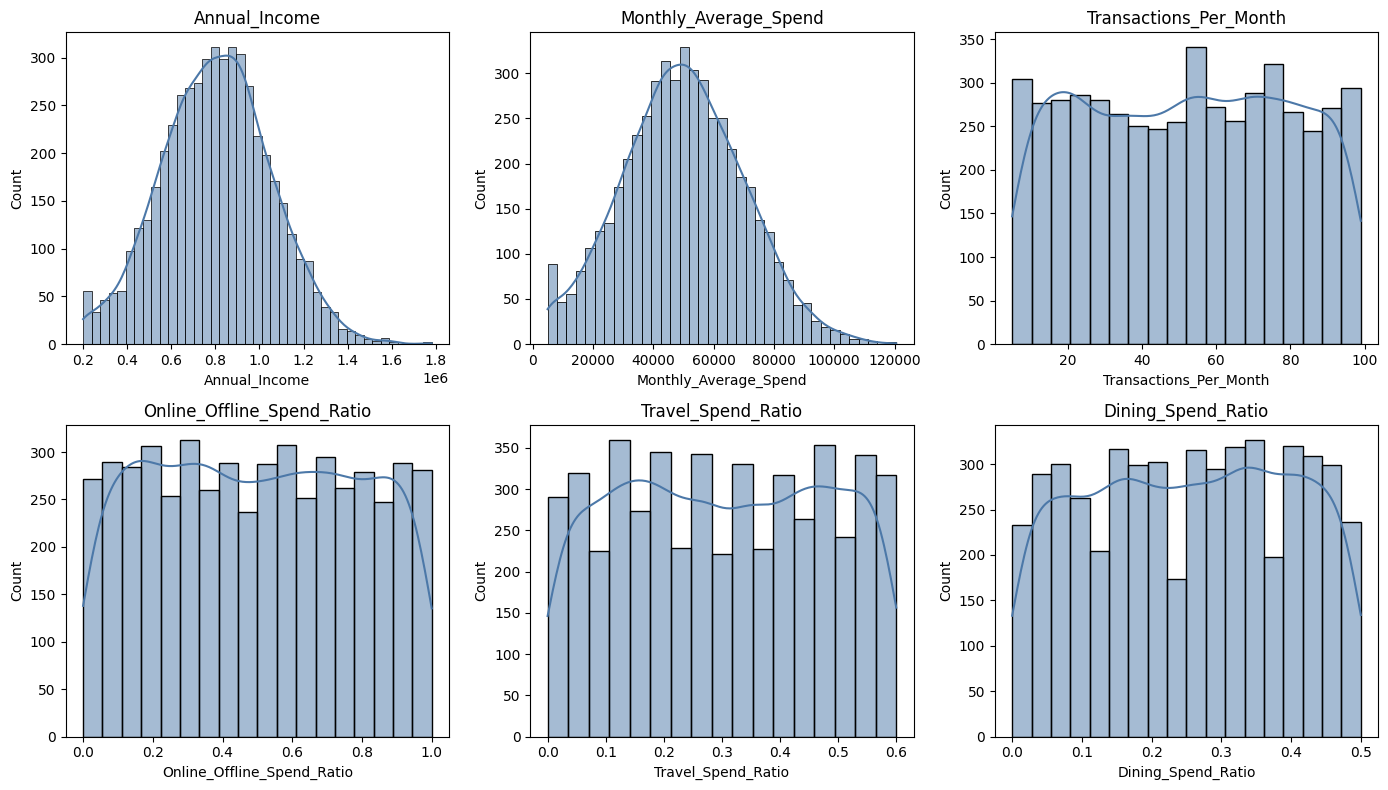

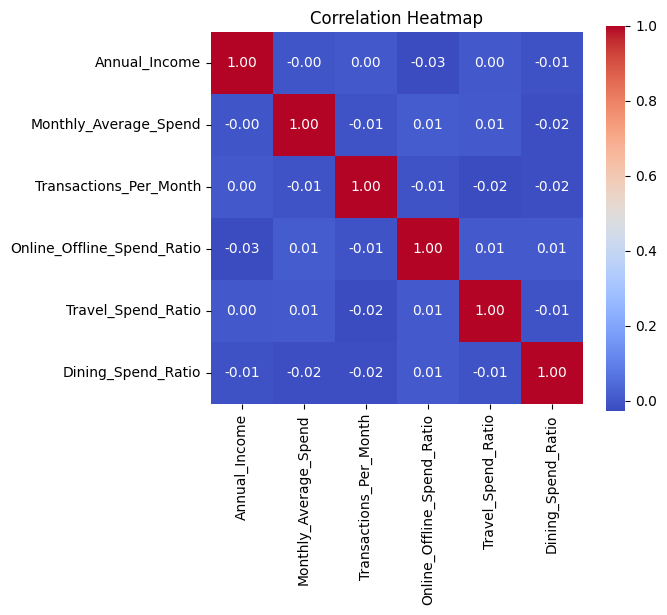

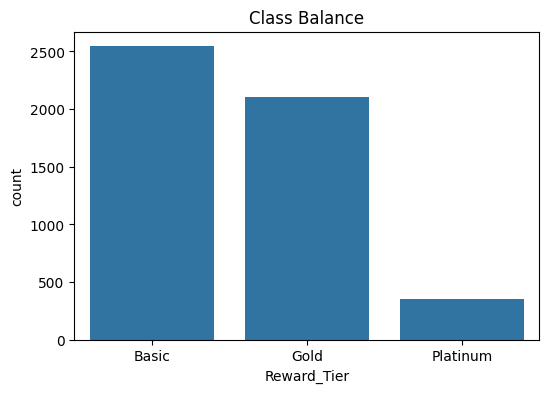

In [6]:
# Visual EDA
import matplotlib.pyplot as plt
import seaborn as sns

numeric_cols = ['Annual_Income','Monthly_Average_Spend','Transactions_Per_Month',
                'Online_Offline_Spend_Ratio','Travel_Spend_Ratio','Dining_Spend_Ratio']

fig, axes = plt.subplots(2, 3, figsize=(14, 8))
axes = axes.ravel()
for i, col in enumerate(numeric_cols):
    sns.histplot(df[col], kde=True, ax=axes[i], color='#4C78A8')
    axes[i].set_title(col)
plt.tight_layout()
plt.show()

plt.figure(figsize=(6,5))
sns.heatmap(df[numeric_cols].corr(), annot=True, cmap='coolwarm', fmt='.2f', square=True)
plt.title('Correlation Heatmap')
plt.show()

plt.figure(figsize=(6,4))
sns.countplot(data=df, x='Reward_Tier', order=sorted(df['Reward_Tier'].unique()))
plt.title('Class Balance')
plt.show()


In [7]:
# Train/test split and pipeline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier

feature_cols = ['Annual_Income','Monthly_Average_Spend','Transactions_Per_Month',
                'Online_Offline_Spend_Ratio','Travel_Spend_Ratio','Dining_Spend_Ratio']
X = df[feature_cols]
y = df['Reward_Tier']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

model = Pipeline(steps=[
    ('scaler', StandardScaler()),
    ('rf', RandomForestClassifier(n_estimators=300, random_state=42))
])


Accuracy: 0.930

Classification Report:
               precision    recall  f1-score   support

       Basic       0.93      1.00      0.96       509
        Gold       0.93      1.00      0.96       421
    Platinum       0.00      0.00      0.00        70

    accuracy                           0.93      1000
   macro avg       0.62      0.67      0.64      1000
weighted avg       0.86      0.93      0.90      1000



/Users/naureenfathima/my-code/data-science/data-science-explore/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/naureenfathima/my-code/data-science/data-science-explore/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/naureenfathima/my-code/data-science/data-science-explore/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use 

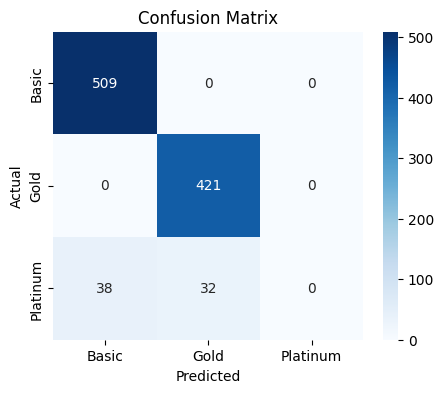


Feature Importances:
Annual_Income                 0.438038
Monthly_Average_Spend         0.409491
Transactions_Per_Month        0.040646
Online_Offline_Spend_Ratio    0.039065
Travel_Spend_Ratio            0.037253
Dining_Spend_Ratio            0.035507
dtype: float64


In [8]:
# Train and evaluate
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
acc = accuracy_score(y_test, y_pred)
print(f'Accuracy: {acc:.3f}')
print('\nClassification Report:\n', classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred, labels=sorted(y.unique()))

import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=sorted(y.unique()), yticklabels=sorted(y.unique()))
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Feature importance (from RandomForest)
rf = model.named_steps['rf']
try:
    importances = rf.feature_importances_
    fi = pd.Series(importances, index=feature_cols).sort_values(ascending=False)
    print('\nFeature Importances:')
    print(fi)
except Exception as e:
    print('Could not compute feature importances:', e)


## Notes and potential improvements
- Use `Transaction_Summary` with NLP features (e.g., TF-IDF) to capture context like travel/dining keywords.
- Try other models and tuning (Logistic Regression, XGBoost/LightGBM, SVM; use cross-validated `GridSearchCV`).
- Calibrate probabilities and define operating thresholds per business KPI.
- Balance classes if skewed (class weights or resampling).
- Add time-based validation if there is temporal drift.
- Add fairness/robustness checks and monitoring in production.

### Example: predicting on a new customer
```python
new_customer = pd.DataFrame([
    {
        'Annual_Income': 800000,
        'Monthly_Average_Spend': 40000,
        'Transactions_Per_Month': 30,
        'Online_Offline_Spend_Ratio': 0.6,
        'Travel_Spend_Ratio': 0.2,
        'Dining_Spend_Ratio': 0.3,
    }
])
model.predict(new_customer)[0]
```


In [9]:
# Cross-validated evaluation (optional)
from sklearn.model_selection import cross_val_score, StratifiedKFold

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(model, X, y, cv=cv, scoring='accuracy', n_jobs=-1)
print('CV Accuracy: mean={:.3f}, std={:.3f}'.format(cv_scores.mean(), cv_scores.std()))


CV Accuracy: mean=0.930, std=0.000


In [10]:
# Extended pipeline using Transaction_Summary text features (optional)
from sklearn.compose import ColumnTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression

numeric_features = ['Annual_Income','Monthly_Average_Spend','Transactions_Per_Month',
                    'Online_Offline_Spend_Ratio','Travel_Spend_Ratio','Dining_Spend_Ratio']
text_feature = 'Transaction_Summary'

preprocess = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(with_mean=True, with_std=True), numeric_features),
        ('txt', TfidfVectorizer(max_features=500, ngram_range=(1,2)), text_feature)
    ], remainder='drop'
)

text_model = Pipeline(steps=[
    ('prep', preprocess),
    ('clf', LogisticRegression(max_iter=1000, class_weight='balanced', n_jobs=-1))
])

X_full = df[numeric_features + [text_feature]]
y_full = df['Reward_Tier']

X_train_f, X_test_f, y_train_f, y_test_f = train_test_split(
    X_full, y_full, test_size=0.2, random_state=42, stratify=y_full
)

text_model.fit(X_train_f, y_train_f)

pred_f = text_model.predict(X_test_f)
print('Extended pipeline Accuracy:', accuracy_score(y_test_f, pred_f))


Extended pipeline Accuracy: 0.612


## Observations (from quick EDA)
- **Income and spend levels** show wide variance; spend ratios distribute across 0–1 as expected.
- **Correlations** among numeric features are modest; no single dominant linear driver.
- **Class balance** appears reasonable but verify exact proportions in your run.

## Model performance (what to look for when you run)
- **Holdout metrics**: accuracy, confusion matrix, precision/recall per class in the classification report.
- **Feature importances** (RF) help indicate which numeric signals matter most.
- **CV accuracy** gives stability across folds.

## Practical improvements
- **Text signals**: incorporate `Transaction_Summary` (TF-IDF) — included in optional pipeline; consider n-gram tuning and stopwords.
- **Hyperparameter tuning**: cross-validated search for RF/LogReg/XGBoost with stratified folds.
- **Calibration**: use probability calibration and set class thresholds per business KPIs.
- **Fairness and drift**: monitor segment-level performance and re-train on fresh data.
- **Deployment**: export `Pipeline` via `joblib` and wrap with input validation for inference.
